# Predicting MOA on Validation Screen Data

Quick test to see if we can predict compound mechanism of action based on morphological features. This is using a [random forest classifier](https://en.wikipedia.org/wiki/Random_forest) without much optimisation, so the classification accuracies can definitely be improved with feature selection etc.

## Load and tidy data

In [1]:
from __future__ import division, print_function
import pandas as pd
import numpy as np
import sklearn
from sklearn import ensemble
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

print("sklearn version\t", sklearn.__version__)
print("numpy version \t", np.__version__)
print("pandas version \t", pd.__version__)

# matplotlib setup
%matplotlib inline
plt.style.use("bmh")

# load data
url = "https://dl.dropboxusercontent.com/u/79810285/df_cell_subclass.csv"
df = pd.read_csv(url)

# remove controls and low concentrations from the data
df = df[df.Metadata_compound != "DMSO"]
df = df[df.Metadata_concentration >= 100]

sklearn version	 0.17.1
numpy version 	 1.10.1
pandas version 	 0.17.1


## Compounds and MOA

List of compounds and their mechanism of action:

In [2]:
compound = list(df["Metadata_compound"])
MOA = list(df["Metadata_compoundClass"])
pd.DataFrame(zip(compound, MOA), columns = ["compound", "MOA"]).drop_duplicates()

,compound,MOA
0,paclitaxel,microtubule disrupting
18,ARQ-621,microtubule disrupting
19,nocodazole,microtubule disrupting
20,monastrol,microtubule disrupting
72,ZM447439,microtubule disrupting
74,barasertib,microtubule disrupting
216,cytochalasin D,actin disrupting
234,cytochalasin B,actin disrupting
235,lantrunculin-B,actin disrupting
239,jaksplakinolide,actin disrupting


### Separate into measurements and MOA labels

For the classification tasks, I need to create two arrays, one of the feature data, and the other as the MOA coverted into integer labels

In [3]:
# MOA labels
feature_names = df['Metadata_compoundClass']
feature_labels = pd.Categorical(feature_names).codes

# feature data
feature_data = [col for col in list(df.columns) if not col.startswith("Metadata")]
feature_data = np.array(df[feature_data])
# normalise feature data
feature_data = preprocessing.scale(feature_data)

Now we split the data into training and test sets, and train the random forest classifier on the training dataset. 

Then see how well we can predict the mechanism of action on the test data without any labels. We then compare the predicted labels to the actual labels that we have held back.

In [4]:
# generate training and test datasets
data_train, data_test, label_train, label_test = train_test_split(
    feature_data,
    feature_labels,
    test_size=0.33)

clf = ensemble.RandomForestClassifier(n_estimators=650,
                                      n_jobs=-1,
                                      min_samples_split=3,
                                      max_features=0.8)
clf.fit(data_train, label_train)
predictions = clf.predict(data_test)
perc_correct = clf.score(data_test, label_test) * 100

Now plot a confusion matrix so we can see which MOAs are well classified, and which are often mis-labelled.

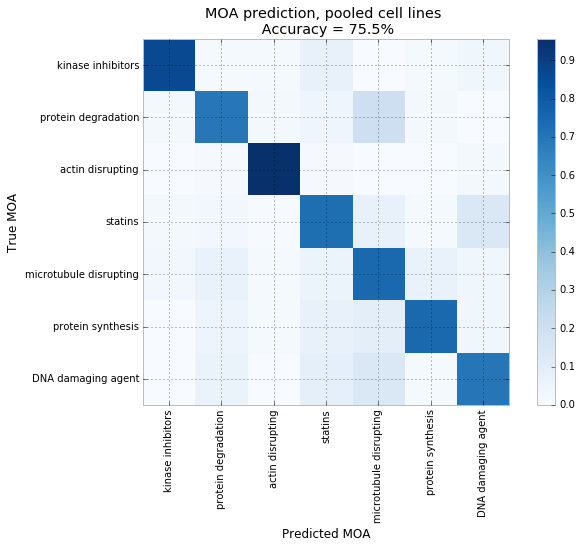

In [6]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    "Function to plot a confusion matrix"
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    tick_marks = np.arange(len(set(feature_names)))
    plt.xticks(tick_marks, set(feature_names), rotation = 90)
    plt.yticks(tick_marks, set(feature_names))
    plt.ylabel('True MOA')
    plt.xlabel('Predicted MOA')


cm = confusion_matrix(label_test, predictions)
# normalise the confusion matrix to account for different sized groups
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8,6))
plot_confusion_matrix(cm_norm,
                     title = "MOA prediction, pooled cell lines \n Accuracy = {0:.1f}%".format(perc_correct))
plt.show()


# Separated by cell line

Now we will try predicting mechanism of action on each cell line individually, see is there are any striking differences between the cell lines in our ability to predict MOA.

Two possibilities:
1. Classification accuracy will *increase* because the cell lines have slightly different responses to the compounds.
2. Classification accuracy will *decrease* simply because there's 1/8th of the data to train an accurate model.

In [9]:
# select just MDA-MB-231 data
mda = df[df.Metadata_CellLine == "MDA231"]

# MOA labels
feature_names = mda['Metadata_compoundClass']
feature_labels = pd.Categorical(feature_names).codes

# feature data
feature_data = [col for col in list(mda.columns) if not col.startswith("Metadata")]
feature_data = np.array(mda[feature_data])

# generate training and test datasets
data_train, data_test, label_train, label_test = train_test_split(
    feature_data,
    feature_labels,
    test_size=0.33)

# train classifier on training data and predict labels on test data
clf = ensemble.RandomForestClassifier(n_estimators=650,
                                      n_jobs=-1,
                                      min_samples_split=3,
                                      max_features=0.8)
clf.fit(data_train, label_train)
predictions = clf.predict(data_test)

# determine prediction accuracy by comparing to known labels
perc_correct = clf.score(data_test, label_test) * 100

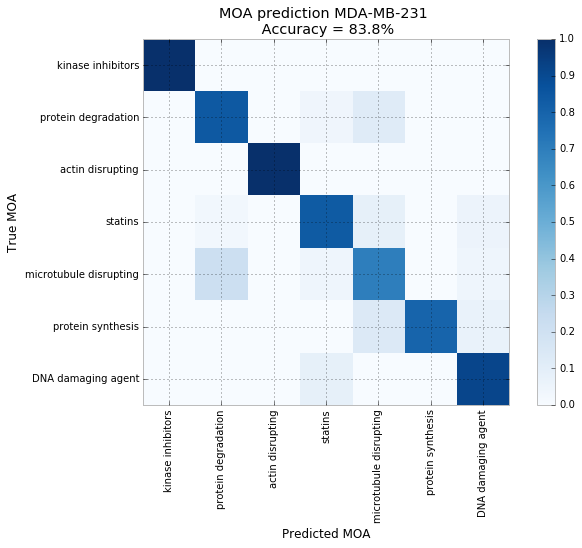

In [10]:
# create confusion matrix
cm = confusion_matrix(label_test, predictions)
# normalise the confusion matrix to account for different sized groups
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# plot
plt.figure(figsize=(8,6))
plot_confusion_matrix(cm_norm,
                     title = "MOA prediction MDA-MB-231 \n Accuracy = {0:.1f}%".format(perc_correct))
plt.show()


For the MDA-MB-231 cell line we get an accuracy of 80-90%.

## Bootstrapping the random forest

Now let's try bootstrapping this 10 times to observe an average accuracy.

In [11]:
def bootstrap_rforest(n):
    """
    Repeat random forest classification with
    random sampling 'n' times
    """
    accuracy = []

    # create classifier
    clf = ensemble.RandomForestClassifier(n_estimators=650,
                                 n_jobs=-1,
                                 min_samples_split=3,
                                 max_features=0.8)
    
    for i in range(0, n):
        # split into training and test datasets 
        data_train, data_test, label_train, label_test = train_test_split(
            feature_data,
            feature_labels,
            test_size=0.33)
        
        # predict MOA labels
        clf.fit(data_train, label_train)
        predictions = clf.predict(data_test)
        # determine percentage of correctly labelled MOAs
        perc_correct = clf.score(data_test, label_test) * 100
        accuracy.append(perc_correct)
        
    return accuracy
    
out = bootstrap_rforest(10)

print("Average accuracy for MDA-MB-231 classification = %.1f"
      %np.mean(out), "%")

Average accuracy for MDA-MB-231 classification = 85.6 %


## Computing classification accuracy for each cell line

Since we have 8 different cell lines, it would be interesting to know if there are any cell lines with particularly good or poor classification accuracy.

So we will compute the bootstrapped random forest classification task for each cell line and compare.

In [12]:
# this is going to take a bit of setting up

def subset_cell_line(cell_line, data = df, col = "Metadata_CellLine"):
    """
    subset a given dataframe to contain
    data only from a single cell line
    """
    return data[data[col] == cell_line]


def split_data(data, moa_col="Metadata_compoundClass"):
    """
    split data into features and labels
    returns: two arrays:
    1: data
    2: labels
    """
    # feature labels
    feature_names = data['Metadata_compoundClass']
    feature_labels = pd.Categorical(feature_names).codes
    # feature data
    feature_data = [col for col in list(data.columns) if not col.startswith("Metadata")]
    feature_data = np.array(data[feature_data])
    return [feature_data, feature_labels]
    


def train_r_forest(X, Y, n_estimators):
    """
    train a random forest classifier for a given array (X) and labels (Y).
    Returns the percentage classification accuracy
    """
    # split into training and test datasets
    d_train, d_test, l_train, l_test = train_test_split(X, Y, test_size=0.33)
    # create classifier
    clf = ensemble.RandomForestClassifier(n_estimators,
                                 n_jobs=-1,
                                 max_features=0.8,
                                 min_samples_split=3)
    # train model on training data
    clf.fit(d_train, l_train)
    # test model on test data
    predictions = clf.predict(d_test)
    # determine accuracy of predictions
    perc_correct = clf.score(d_test, l_test) * 100
    return perc_correct
    
    
def bootstrap_forest(X, Y,  n_sample=10, n_estimators=650):
    """
    Bootstrap random forest classification and
    return average classification accuracy
    """
    pred_accuracy = []
    for i in range(0, n_sample):
        acc_out = train_r_forest(X, Y, n_estimators)
        pred_accuracy.append(acc_out)
    return np.mean(pred_accuracy)


def main_r_forest(cell_line):
    data = subset_cell_line(cell_line)
    X, Y = split_data(data)
    accuracy = bootstrap_forest(X, Y)
    return (cell_line, accuracy)

In [13]:
cell_lines = list(set(df.Metadata_CellLine))
accuracy_out = [main_r_forest(cl) for cl in cell_lines]
dat = pd.DataFrame(accuracy_out, columns= ["cell line", "MOA accuracy(%)"])

In [14]:
dat

,cell line,MOA accuracy(%)
0,HCC1954,77.633588
1,SKBR3,81.755725
2,MCF7,85.877863
3,KPL4,82.671756
4,T47D,80.538462
5,MDA231,87.230769
6,MDA157,76.422764
7,HCC1569,78.549618


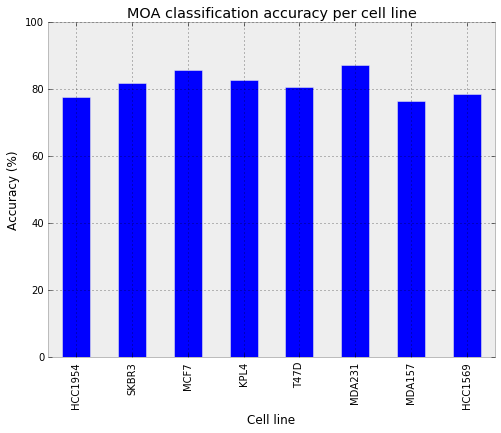

In [17]:
tick_marks = np.arange(len(cell_lines))
dat.plot(kind="bar", figsize=(8,6), legend=False)
plt.xticks(tick_marks, cell_lines, rotation=90)
plt.ylabel("Accuracy (%)")
plt.xlabel("Cell line")
plt.ylim(0,100)
plt.title("MOA classification accuracy per cell line")
plt.show()

We see that classification accuracy varies between 77-88% for the 8 cell lines. It is interesting that MCF7 and MDA-MB-231 have the highest accuracy as there where the two cell lines that I used to optimise the CellProfiler feature extraction pipeline. This makes me think that the classification accuracy is dependent on how accurately the morphological features are extracted for each cell line.


## Mechanism classification accuracy per cell line

We might want to look at the average classification for each mechanism per cell line to determine if one mechanism of always poorly classified, or if it's poorly classified in one particular cell line.

In [21]:
# get the mechanism accuracy separately for each cell line

def round_2pd(x):
    "round to 2 decimal places"
    return format(x, '.2f')

def r_forest_predictions(X, Y, n_estimators=650):
    """
    train a random forest classifier for a given array (X) and labels (Y).
    Returns the percentage classification accuracy
    """
    # split into training and test datasets
    d_train, d_test, l_train, l_test = train_test_split(X, Y, test_size=0.33)
    # create classifier
    clf = ensemble.RandomForestClassifier(n_estimators,
                                          n_jobs=-1,
                                          max_features=0.8,
                                          min_samples_split=3)
    # train model on training data
    clf.fit(d_train, l_train)
    # test model on test data
    predictions = clf.predict(d_test)
    return (predictions, l_test)


def cm_diagonal(Y, predictions):
    "Get the diagonal of the confusion matrix"
    cm = confusion_matrix(Y, predictions)
    # normalise confusion matrix
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    # take diagonal of confusion matrix
    diag = list(np.diag(cm_norm)*100)
    return diag
    


def class_predictions(cell_line):
    data = subset_cell_line(cell_line)
    X, Y = split_data(data)
    predictions, actual = r_forest_predictions(X, Y)
    diag_out = cm_diagonal(actual, predictions)
    return diag_out 


cell_lines = list(set(df.Metadata_CellLine))
pred_out = [class_predictions(cl) for cl in cell_lines]
f_names = set(feature_names)
pd.DataFrame(pred_out, cell_lines, columns = f_names)

,kinase inhibitors,protein degradation,actin disrupting,statins,microtubule disrupting,protein synthesis,DNA damaging agent
HCC1954,91.666667,61.538462,100.000000,78.947368,68.421053,80.000000,76.923077
SKBR3,100.000000,65.384615,90.909091,72.222222,75.000000,69.230769,92.857143
MCF7,100.000000,77.777778,100.000000,93.939394,82.608696,64.705882,90.909091
KPL4,77.777778,68.000000,100.000000,80.000000,76.923077,100.000000,63.636364
T47D,93.333333,85.714286,92.857143,91.891892,70.588235,87.500000,60.000000
MDA231,100.000000,88.000000,100.000000,84.210526,91.666667,90.909091,100.000000
MDA157,84.615385,52.000000,81.818182,82.500000,94.117647,81.818182,66.666667
HCC1569,83.333333,81.818182,90.909091,89.189189,69.565217,90.000000,70.000000


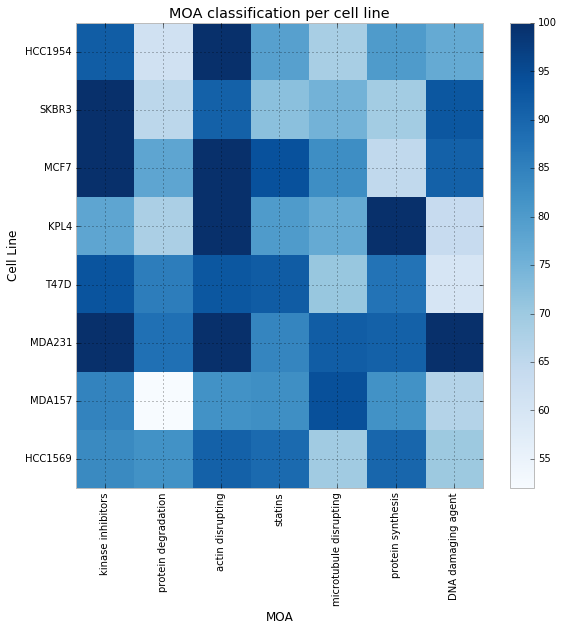

In [22]:
pred_array = np.array(pred_out)

x_tick_marks = np.arange(len(f_names))
y_tick_marks = np.arange(len(cell_lines))

plt.figure(figsize=(8,7))
plt.imshow(pred_array, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.tight_layout()
plt.xticks(x_tick_marks, f_names, rotation = 90)
plt.yticks(y_tick_marks, cell_lines)
plt.ylabel('Cell Line')
plt.xlabel('MOA')
plt.title("MOA classification per cell line")
plt.show()

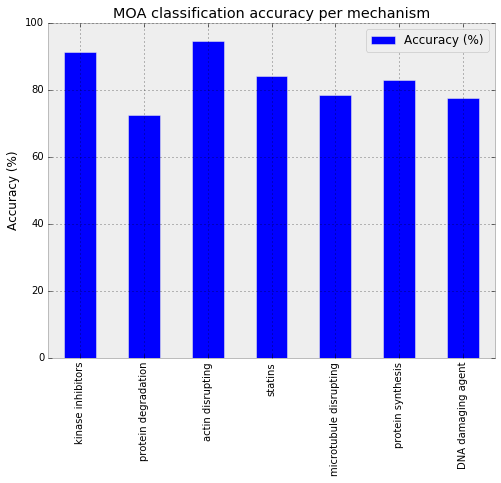

In [24]:
# plot average accuracy per mechanism
class_acc = list(pred_array.mean(axis=0))
pd.DataFrame(zip(f_names, class_acc),
             columns = ["MOA", "Accuracy (%)"]).plot(kind="bar", figsize=(8,6))
tick_marks = np.arange(len(f_names))
plt.xticks(tick_marks, f_names, rotation=90)
plt.ylabel("Accuracy (%)")
plt.ylim(0,100)
plt.title("MOA classification accuracy per mechanism")
plt.show()

# Conclusion

- As a first pass we can get some quite decent accuracy at predicting compound mechanism of action. It's likely that this can be improved by 10+% with some more work and optimisation.
- Our accuracy at classifying compounds to MOAs is somewhat dependent on the cell lines, I think this is due to the feature extraction process being better/cleaner on some cell lines over others.